<a href="https://colab.research.google.com/github/imn167/VAE_SS/blob/main/GoM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output #
import time
import openturns as ot

On teste le VAE sur une distribution gaussienne tronquée tel que les coordonnées des vecteurs soient supérieurs à un seuil.  

Pour des soucis d'efficacité et de faisabilité on choisit de tronquer seulement sur 2 coordonnées.

In [2]:
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import scipy.stats as sp


import time

##### Creation of the Sampling class ########

class MoGPrior(layers.Layer):
  def __init__(self, latent_dim, num_components, **kwargs):
    super(MoGPrior, self).__init__(**kwargs)
    self.latent_dim = latent_dim
    self.num_components = num_components

    # means and log variances (trainable parameters)
    self.means = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)),
                            trainable=True, name='means')
    self.logvars = tf.Variable(tf.random.normal(shape=(num_components, latent_dim)),
                               trainable=True, name='logvars')

    # mixing weights (trainable parameter)
    self.w = tf.Variable(tf.random.normal(shape=(1,num_components)), trainable=True)

  def get_params(self):
    return self.means, self.logvars, self.w

  def call(self, batch_size):
    # get means and log variances of the mixture
    means, logvars, w = self.get_params()

    # normalize mixing weights using softmax (see gumball)
    w = tf.nn.softmax(self.w, axis=1)
    # sample component indices
    indexes = (tf.random.categorical(tf.math.log(w), batch_size))[0]

    # sample from chosen components
    z = tf.map_fn(fn= lambda indx : means[indx] + tf.random.normal(shape= (1,2)) * tf.exp(0.5*logvars[indx]),
          elems= indexes,
          dtype=tf.float32)
    z = tf.squeeze(z)

    return z
  #compute the log_density of each gaussian at the point z
  def log_normal_diag(self, z, mean, logvar):
     nn_exp = -0.5*( tf.math.log(2.0*np.pi) + logvar)
     exp = -0.5* (z-mean)**2 * (tf.exp(-logvar))
     return tf.reduce_sum(nn_exp + exp, axis = -1)

  def log_prob(self, z):
     #getting means and vars of the gausiian mixture
     means, logvars, w = self.get_params()

     #normalising the weight with the softmax transformation
     w = tf.transpose(tf.nn.softmax(w, axis=1))
     #reshape for broadcast
     z =  tf.expand_dims(z, axis=0) #1 x batch x latent_dim
     means = tf.expand_dims(means, axis=1) #num_compo x 1 x latent_dim
     logvars = tf.expand_dims(logvars, axis=1) #num_compo x 1 x latent_dim

     #we compute the log of each gaussian for each z
     log_p = self.log_normal_diag(z, means, logvars) + tf.math.log(w) #num_compo x batch
     prob = tf.reduce_logsumexp(tf.squeeze(log_p), axis=0) #log(sum(exp())) #batch
     return prob


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape= (batch, dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

##### Creation of the Encoder Class #####
class Encoder(layers.Layer):
  def __init__(self, input_dim, latent_dim, **kwargs):
    super(Encoder, self).__init__(name='encoder', **kwargs)
    self.enc1 = layers.Dense(input_dim, activation='relu')
    self.enc2 = layers.Dense(64, activation = 'relu')
    self.enc3 = layers.Dense(32, activation = 'relu')
    self.mean_z = layers.Dense(latent_dim, name = 'z_mean')
    self.logvar_z = layers.Dense(latent_dim, name = 'z_log_var')
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.enc1(inputs)
    x = self.enc2(x)
    x = self.enc3(x)
    z_mean = self.mean_z(x)
    z_log_var = self.logvar_z(x)
    z = self.sampling([z_mean, z_log_var])
    return z_mean, z_log_var, z



############## Creation of the Decoder Class #################
class Decoder(layers.Layer):

 def __init__(self,input_dim, latent_dim, **kwargs):
    super(Decoder, self).__init__(name='decoder', **kwargs)
    self.dec1 = layers.Dense(latent_dim, activation='relu' )
    self.dec2 = layers.Dense(32, activation='relu')
    self.dec3 = layers.Dense(64, activation='relu')
    self.out = layers.Dense(input_dim, name = 'x_out')
    self.x_log_var = layers.Dense(input_dim, name = 'x_log_var')

 def call(self, z):
   z = self.dec1(z)
   z = self.dec2(z)
   z = self.dec3(z)
   return self.out(z), self.x_log_var(z)


##################### Creation of subclass od Model : VAE ########################
## We can see the subclass VAE as a Keras Model therefore it has the several method as fit and compile
## We overwrite the train function of the model : train_step (customizing the training)
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, prior, **kwargs):
        super(VAE, self).__init__(name = 'vae', **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

        self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name = 'kl_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name = 'reconstruction_loss')

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction, x_log_var = self.decoder(z)
        #batch = tf.shape(z_mean)[0]
        #prior_sample = self.prior(batch)
        return z_mean, z_log_var, reconstruction, x_log_var, z

    def get_encoder_decoder(self):
        return self.encoder, self.decoder

    def train_step(self, data):
       # data, y = data
        #y = tf.reshape(y,[-1])
        with tf.GradientTape() as tape :

            z_mean, z_log_var, reconstruction, x_log_var, z = self(data)
            #we compute the first loss : the log-likelyhood
            scale_x = tf.exp(x_log_var) #variance
            log_pdf = 0.5 * tf.reduce_sum(tf.pow(data-reconstruction, 2) / scale_x + x_log_var, axis = 1) #-log_pdf because we want to maximise it (SGD aim to minimize in keras)
            reconstruction_loss =  tf.reduce_mean(log_pdf) #tf.multiply(log_pdf, y)
            entropy =  tf.reduce_sum(-0.5 * (tf.math.log(2.0*np.pi) + 1 +  z_log_var), axis=1 )
            cross_entropy= self.prior.log_prob(z)
            kl_loss = tf.reduce_mean(entropy -cross_entropy)
            total_loss =( reconstruction_loss + kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}





In [7]:
one_mode = np.load("3_component_1Side_truncated (1).npy")
d = one_mode.shape[1]

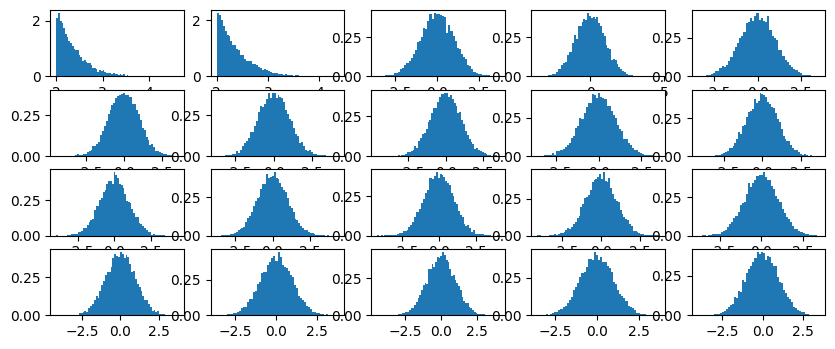

In [8]:
plt.figure(figsize=(10,5))
for i in range(d):
  plt.subplot(5,5, i+1)
  plt.hist(one_mode[:,i], density=True, bins = 'auto');

In [39]:
encoder = Encoder(d,2)
decoder = Decoder(d,2)
mixture = MoGPrior(2,2)
vae = VAE(encoder, decoder, mixture)
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001))
history = vae.fit(one_mode,epochs=100,
    batch_size=100,
    shuffle=True)

Epoch 1/100
100/100 [==============================] - 2s 2ms/step - loss: 12.1224 - kl_loss: 0.5046 - reconstruction_loss: 11.6177
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 9.3535 - kl_loss: 0.4507 - reconstruction_loss: 8.9028
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 8.2494 - kl_loss: 0.3165 - reconstruction_loss: 7.9329
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 8.0373 - kl_loss: 0.2396 - reconstruction_loss: 7.7977
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 7.9692 - kl_loss: 0.1880 - reconstruction_loss: 7.7812
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 7.9254 - kl_loss: 0.1455 - reconstruction_loss: 7.7799
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 7.8988 - kl_loss: 0.1236 - reconstruction_loss: 7.7752
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 7.8876 - kl_l

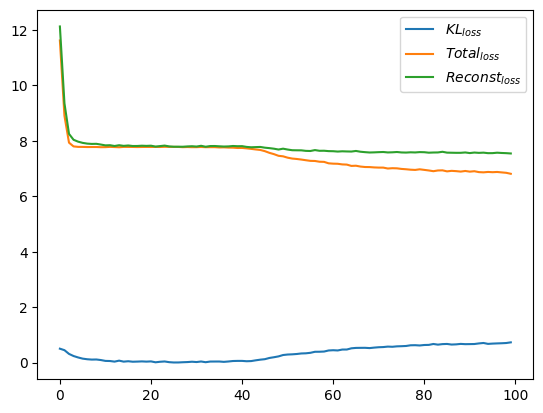

In [40]:
plt.plot(history.history['kl_loss'],  label = r'$KL_{loss}$')
plt.plot(history.history['reconstruction_loss'],  label = r'$Total_{loss}$')
plt.plot(history.history['loss'],  label = r'$Reconst_{loss}$')
plt.legend()

In [41]:
mixture.means

<tf.Variable 'means:0' shape=(2, 2) dtype=float32, numpy=
array([[ 1.4204575 , -0.09353295],
       [ 0.48210606, -0.22743167]], dtype=float32)>

In [43]:
tf.exp(mixture.logvars*0.5)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.0702268 , 0.9143166 ],
       [0.62984425, 0.87809086]], dtype=float32)>

In [44]:
weights = tf.nn.softmax(mixture.w)
weights

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.841513  , 0.15848704]], dtype=float32)>

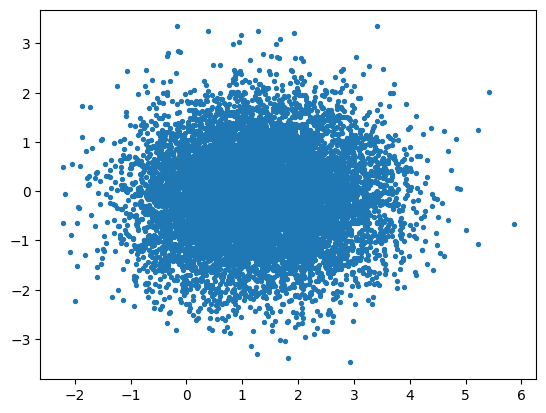

In [45]:
ColDist = [ot.Normal(np.array(mu), np.exp(0.5*np.array(sigma))) for mu, sigma in zip(mixture.means, mixture.logvars)]
weight = np.array(tf.nn.softmax(mixture.w, axis =1)).reshape(-1)
myMixture = ot.Mixture(ColDist, weight)
samples =myMixture.getSample(10000)
plt.scatter(samples[:,0], samples[:,1], s=8)

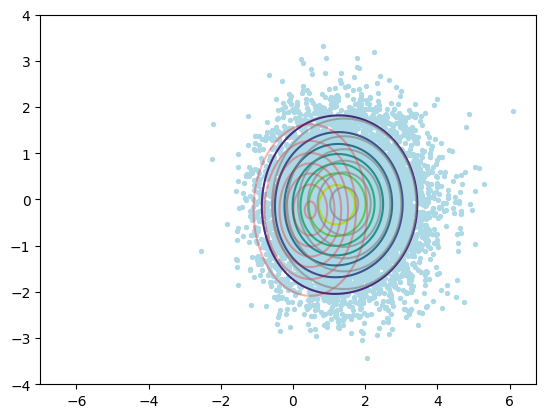

In [53]:
X, Y = np.meshgrid(np.linspace(-7,5, 1000), np.linspace(-4,4, 1000))
pos = np.dstack((X,Y))
from scipy.stats import multivariate_normal
rv1  = multivariate_normal(mixture.means[0], np.diag(tf.exp(mixture.logvars[0]*0.5))) 
rv2  = multivariate_normal(mixture.means[1], np.diag(tf.exp(mixture.logvars[1]*0.5)))
#rv3  = multivariate_normal(mixture.means[2], np.diag(tf.exp(mixture.logvars[2]*0.5)))

Z    = rv1.pdf(pos) * weights[0,0] + rv2.pdf(pos) * weights[0,1] #+ rv3.pdf(pos) * weights[0,2]

plt.contour(X, Y, Z)
plt.contour(X,Y, rv2.pdf(pos), colors = 'red', alpha = .3)
plt.contour(X,Y, rv1.pdf(pos), colors = 'gray', alpha = .6)
_,_, z = encoder(one_mode)
plt.scatter(z[:, 0],z[:,1], s=8, c = 'lightblue');

In [54]:
_,_, z = encoder(one_mode)
mean_x, log_var_x = decoder(z) #we get each mean and log variance of the several distribution then we sample from it

sample = np.random.normal(loc=mean_x, scale= tf.exp(log_var_x/2))

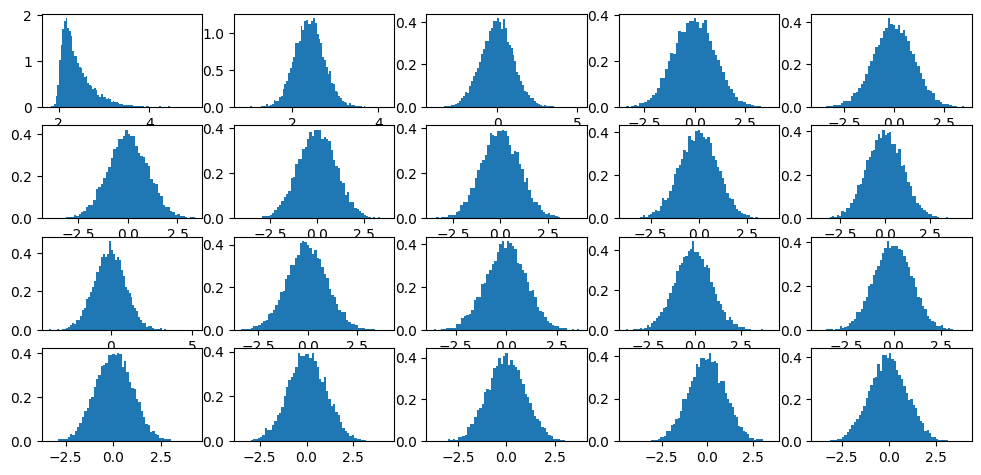

In [55]:
plt.figure(figsize = (12,7))
for i in range(d):
  plt.subplot(5,5,i+1)
  plt.hist(sample[:,i], bins = 'auto', density=True);

Difficulté à reperer la 2e composantes 

In [57]:
class AutoEncoder(tf.keras.Model):
  def __init__(self, encoder,decoder, **kwargs):
    super(AutoEncoder, self).__init__(name='auto-encoder', **kwargs)
    self.encoder = encoder
    self.decoder = decoder

    self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')

  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    x_mean, x_log_var = self.decoder(z)
    return z_mean, z_log_var, z, x_mean, x_log_var 

  def train_step(self, data):


    with tf.GradientTape() as tape :

            _, _, z, reconstruction, x_log_var = self(data)
            #we compute the first loss : the log-likelyhood
            scale_x = tf.exp(x_log_var) #variance
            log_pdf = 0.5 * tf.reduce_sum(tf.pow(data-reconstruction, 2) / scale_x + x_log_var, axis = 1) #-log_pdf because we want to maximise it (SGD aim to minimize in keras)
            total_loss =  tf.reduce_mean(log_pdf) #tf.multiply(log_pdf, y)

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    self.loss_tracker.update_state(total_loss)
    return {m.name: m.result() for m in self.metrics}

In [61]:
encoder = Encoder(d, 2)
decoder = Decoder(d,2)
ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3))
ae.fit(one_mode,epochs=200, batch_size=128, shuffle=True)

Epoch 1/200
79/79 [==============================] - 2s 2ms/step - loss: 10.3093
Epoch 2/200
79/79 [==============================] - 0s 2ms/step - loss: 8.7438
Epoch 3/200
79/79 [==============================] - 0s 2ms/step - loss: 8.5837
Epoch 4/200
79/79 [==============================] - 0s 2ms/step - loss: 8.5628
Epoch 5/200
79/79 [==============================] - 0s 2ms/step - loss: 8.5352
Epoch 6/200
79/79 [==============================] - 0s 2ms/step - loss: 8.4812
Epoch 7/200
79/79 [==============================] - 0s 2ms/step - loss: 8.4277
Epoch 8/200
79/79 [==============================] - 0s 2ms/step - loss: 8.3415
Epoch 9/200
79/79 [==============================] - 0s 2ms/step - loss: 8.2329
Epoch 10/200
79/79 [==============================] - 0s 2ms/step - loss: 8.1590
Epoch 11/200
79/79 [==============================] - 0s 2ms/step - loss: 8.0885
Epoch 12/200
79/79 [==============================] - 0s 2ms/step - loss: 8.0496
Epoch 13/200
79/79 [================

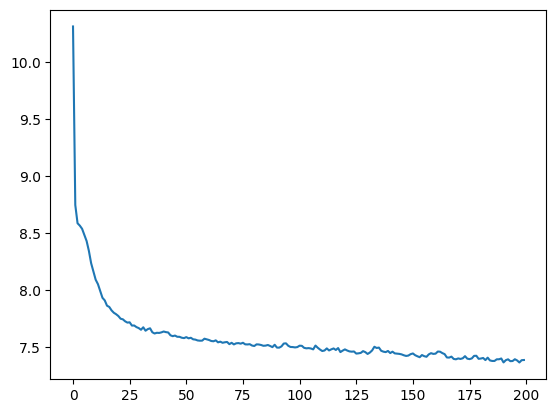

In [62]:
plt.plot(ae.history.history['loss'])

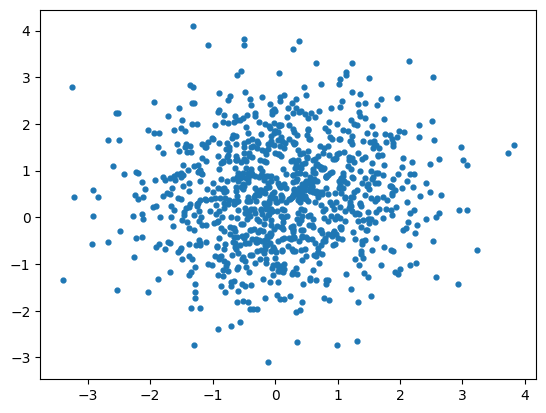

In [66]:
plt.scatter(samples[:,0], samples[:,1], s=12)
plt.scatter(z)

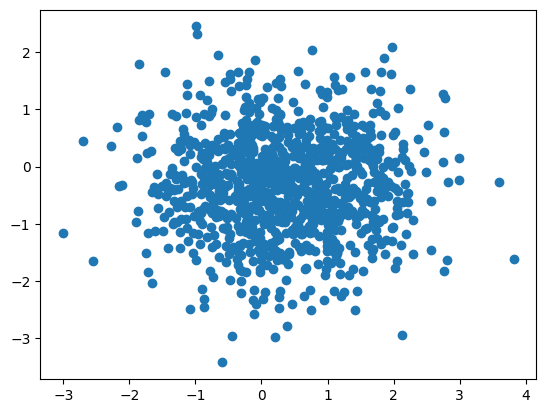

In [79]:
sample = mixture(1000)
plt.scatter(sample[:, 0], sample[:, 1])
